In [1]:
import parselmouth as pm
import numpy as np
from fasttrackpy.tracks import OneTrack, CandidateTracks
from fasttrackpy.processors.smoothers import Smoother
import plotly.express as px
import pandas as pd
import polars as pl
import time
from IPython.display import Image
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Read in the sound file with parselmouth

In [2]:
sound = pm.Sound("assets/ay.wav")

In [3]:
candidates = CandidateTracks(
    sound = sound,
    min_max_formant=4000,
    max_max_formant=6000
)

/Users/joseffruehwald/software/fasttrackpy/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/joseffruehwald/software/fasttrackpy/venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [4]:
df = candidates.winner.to_dataframe()

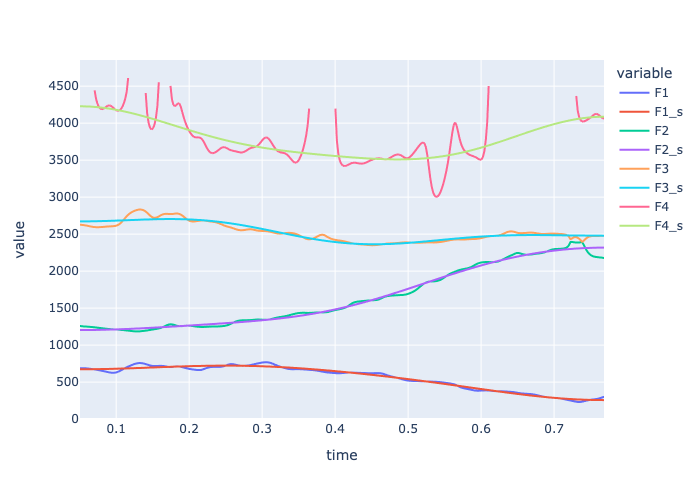

In [6]:
fig = px.line(df, x = "time", y = ["F1", "F1_s", "F2", "F2_s", "F3", "F3_s", "F4", "F4_s"])
Image(fig.to_image(format = "png", engine = "kaleido"))